Variance explained by PCs 1-6: [78.37  5.57  1.14  0.25  0.25  0.24] %


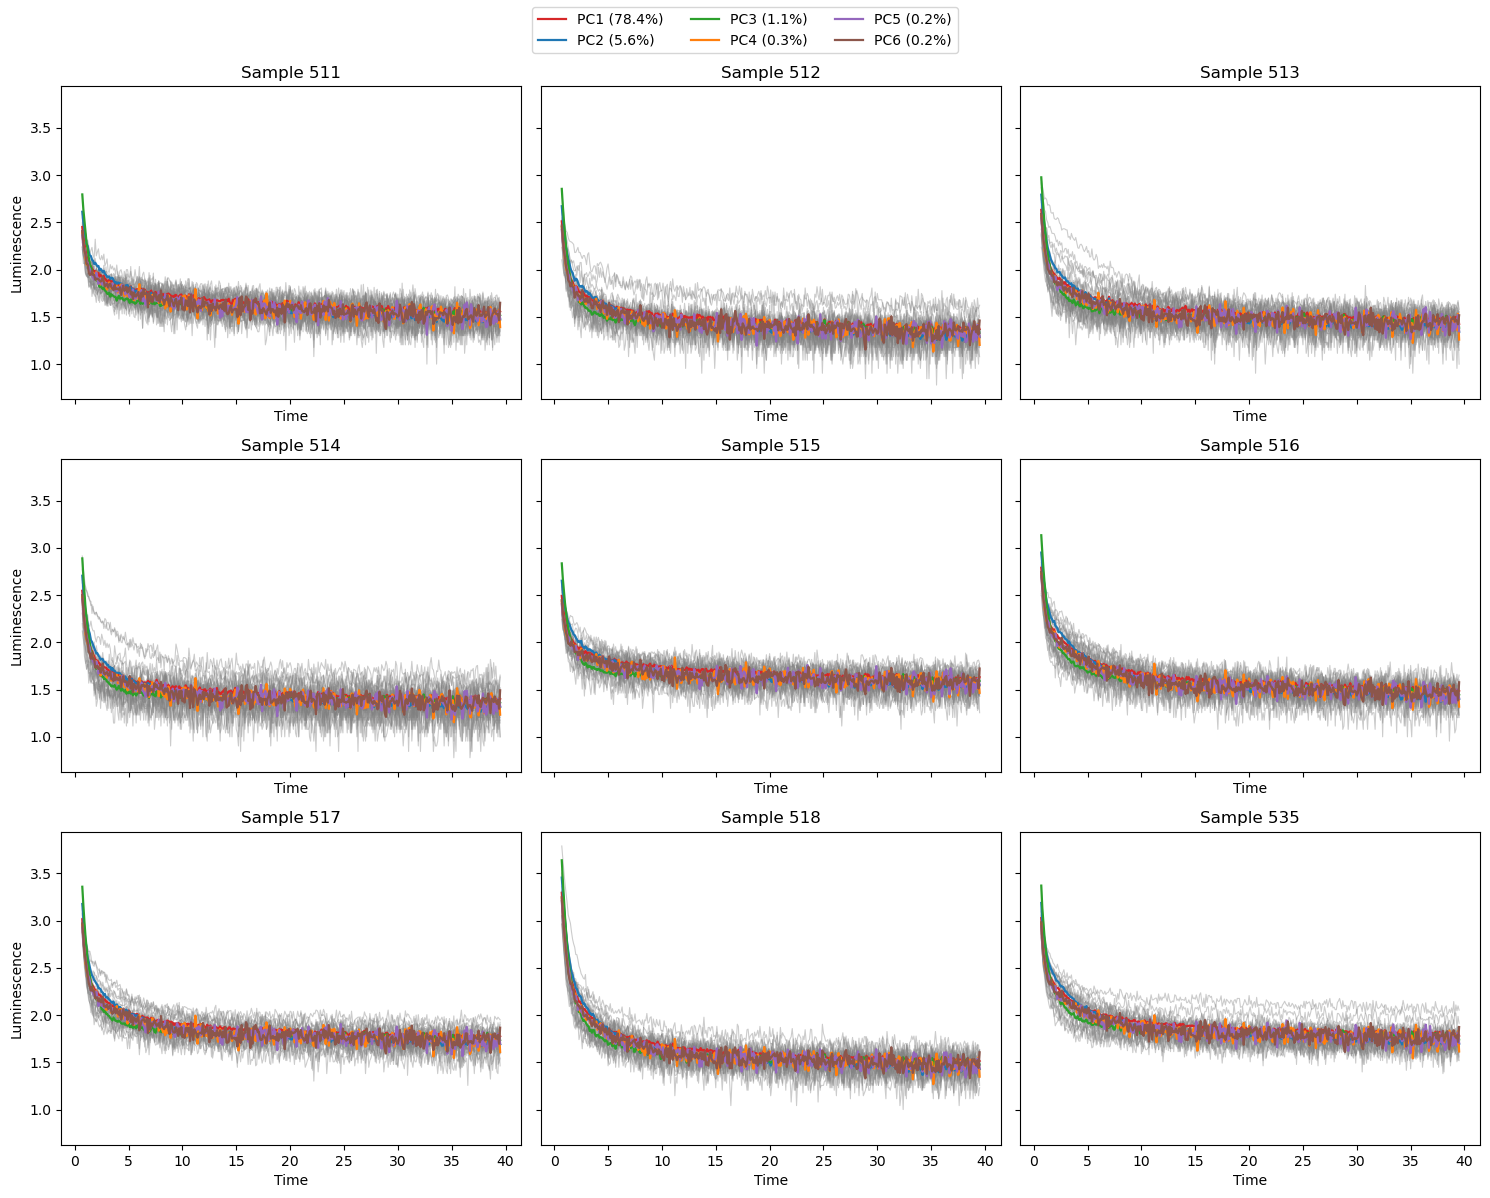

In [4]:
import os, pickle, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ---------------------------------------------------
# load data ---------------------------------------------------
pickle_path = 'output/processed_data.pkl'
if not os.path.exists(pickle_path):
    raise FileNotFoundError("Pickle file not found. Please check the path.")

with open(pickle_path, 'rb') as f:
    data_dict = pickle.load(f)

# helper: return (time, X, slice_names)
def sample_matrix(sample_key):
    df = data_dict[sample_key]
    time = df['Time'].astype(float).values
    slice_cols = df.columns.difference(['Time_index', 'Time'])
    X = df[slice_cols].to_numpy(dtype=float).T          # (n_slices, n_time)
    return time, X, slice_cols

# ---------------------------------------------------
# 1) build a single matrix of all slices -------------
# ---------------------------------------------------
all_slices = []
for key in data_dict:
    _, X, _ = sample_matrix(key)
    all_slices.append(X)
X_all = np.vstack(all_slices)          # shape = (total_slices, n_time)

# centre by column (time-bin) means
X_all_center = X_all - X_all.mean(axis=0, keepdims=True)

# ---------------------------------------------------
# 2) PCA on combined data (first 6 components) -------
# ---------------------------------------------------
n_pc = 6
pca = PCA(n_components=n_pc).fit(X_all_center)
pcs = pca.components_                 # (6, n_time)
var_exp = pca.explained_variance_ratio_ * 100   # percentage

print("Variance explained by PCs 1-6:", np.round(var_exp, 2), "%")

# ---------------------------------------------------
# 3) plot: 3×3 grid, one panel per sample -----------
# ---------------------------------------------------
colors = ['tab:red', 'tab:blue', 'tab:green',
          'tab:orange', 'tab:purple', 'tab:brown']

sample_keys = sorted(data_dict.keys())            # 9 samples
n_rows, n_cols = 3, 3                              # handy for the test below
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12), sharex=True, sharey=True)

for idx, (ax, key) in enumerate(zip(axes.ravel(), sample_keys)):   # <-- note idx
    time, Xs, _ = sample_matrix(key)

    # plot slices (grey)
    ax.plot(time, Xs.T, color='grey', alpha=0.4, lw=0.8)

    # sample-specific mean curve (for offsetting PCs)
    mean_curve = Xs.mean(axis=0)

    # overlay PCs 1-6
    for i in range(n_pc):
        ax.plot(time,
                mean_curve + pcs[i],
                color=colors[i],
                lw=1.6,
                label=f'PC{i+1} ({var_exp[i]:.1f}%)')

    ax.set_title(f'Sample {key}')
    ax.set_xlabel('Time')
    if idx % n_cols == 0:                         # <-- first column?
        ax.set_ylabel('Luminescence')

# common legend across top
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3)

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


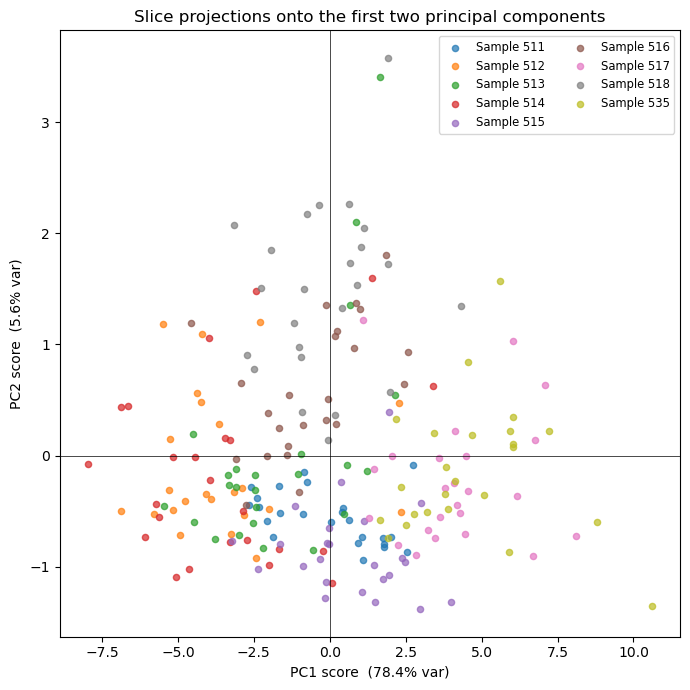

In [5]:
# ---------------------------------------------------
# Scatter of slice scores on PC1 vs PC2 (fixed)
# ---------------------------------------------------
import itertools
import matplotlib.pyplot as plt

# 1. scores = X_centered ⋅ PCsᵀ
scores = X_all_center @ pcs.T           # shape (n_slices_total, n_pc); we use [:,0:2]

# 2. one colour per sample
colour_cycle   = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
sample_colours = {key: next(colour_cycle) for key in sample_keys}

# 3. build an array that records the parent-sample of every slice
slice_sample = []
for key in sample_keys:
    _, X_s, _ = sample_matrix(key)
    slice_sample.extend([key] * X_s.shape[0])      # repeat the key for every slice
slice_sample = np.array(slice_sample)

# 4. scatter plot
plt.figure(figsize=(7, 7))
for key in sample_keys:
    idx = np.flatnonzero(slice_sample == key)
    plt.scatter(scores[idx, 0], scores[idx, 1],
                s=20, alpha=0.7, color=sample_colours[key],
                label=f'Sample {key}')

plt.axhline(0, lw=0.5, color='k')
plt.axvline(0, lw=0.5, color='k')
plt.xlabel(f'PC1 score  ({var_exp[0]:.1f}% var)')
plt.ylabel(f'PC2 score  ({var_exp[1]:.1f}% var)')
plt.title('Slice projections onto the first two principal components')
plt.legend(ncol=2, fontsize='small')
plt.tight_layout()
plt.show()
